In [1]:
import gstools as gs
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.crs as ccrs
from tqdm import tqdm
import xarray as xr
from matplotlib.collections import LineCollection
from matplotlib.colors import LinearSegmentedColormap, Normalize

import matplotlib.cm as cm
from multiprocess import Pool
from scipy.stats import gaussian_kde

import matplotlib.colors as mcolors
import cmcrameri.cm as cmc
from cartopy import geodesic as cgeod
import os
from geopy.distance import geodesic 
import seaborn as sns
from glob import glob

In [2]:
params={     
    'axes.labelsize'  : '16',   
    'axes.titlesize'  : '16',  
    'xtick.labelsize' :'12',
    'ytick.labelsize' :'16',    
    'lines.linewidth' : '2' ,   
    'legend.fontsize' : '12', 
    'figure.figsize'   : '12, 7'    
}
plt.rcParams.update(params)

In [3]:
def extract_era5_ts(extreme_dates, days,ds_cent, ds,var, spec_lat,spec_lon):
    
    date = extreme_dates[days]
    stn_time = ds_cent.sel(time= date).time.values[0]
    # Create timedelta for 12 hours
    # delta = np.timedelta64(12, 'h')
    
    # Calculate timestamps 12 hours before and after
    before = stn_time - np.timedelta64(24, 'h')
    after = stn_time #-np.timedelta64(24, 'h')
    
    val = ds[var].sel(time=slice(before,after)).sel(latitude=spec_lat, longitude =spec_lon,method="nearest").load()

    return val

In [4]:
def extract_era5_all(ds,var,start,end, spec_lat,spec_lon, shift,atype = "max"):
    ## shift hours based on local time
    ## E.g. Brisbane 9 am is 2300 UTC; equivalent to -1 hour for xarray functions 
    ## (there is no time zone change here, only the selection of hours)
    shifted_data = ds.assign_coords(time=ds.time + pd.Timedelta(hours=-1))

    # 2. Resample to daily frequency and calculate max and min
    # daily_max = shifted_data[var].resample(time="1D").max(dim="time").sel(time=slice(start,end)).sel(latitude=spec_lat, longitude =spec_lon,method="nearest")
    # daily_min = shifted_data[var].resample(time="1D").min(dim="time").sel(time=slice(start,end)).sel(latitude=spec_lat, longitude =spec_lon,method="nearest")
    # val_delta = daily_max-daily_min
    if atype=="max":
        daily_max = shifted_data[var].resample(time="1D").max(dim="time").sel(time=slice(start,end)).sel(latitude=spec_lat, longitude =spec_lon,method="nearest")

        return daily_max#, val_delta
    if atype=="min":
        daily_min = shifted_data[var].resample(time="1D").min(dim="time").sel(time=slice(start,end)).sel(latitude=spec_lat, longitude =spec_lon,method="nearest")
        return daily_min#, val_delta
    if atype=="mean":
        daily_mean = shifted_data[var].resample(time="1D").mean(dim="time").sel(time=slice(start,end)).sel(latitude=spec_lat, longitude =spec_lon,method="nearest")

        return daily_mean#, val_delta

In [5]:
def get_bl_cape(spec_id):
    min_scale = 0
    min_year = 1941
    start_yymmdd = "1940-03-02" # 1940-03-02
    end_yymmdd = "2024-05-31"
    

    # Define the start and end dates
    start_date = np.datetime64(start_yymmdd)
    end_date = np.datetime64(end_yymmdd)


    spec_lat, spec_lon = df_center["Latitude"][df_center["ID"]==spec_id].iloc[0], df_center["Longitude"][df_center["ID"]==spec_id].iloc[0]
    
    df_stations_p90 = pd.read_csv(f"/g/data/k10/dl6968/Semi-variogram_AU/data/all_AU_p90/{spec_id}_station_list_all_events.csv")
    
    df_scale_p90 = pd.read_csv(f"/g/data/k10/dl6968/Semi-variogram_AU/data/all_AU_p90/{spec_id}_pair_scale_list_all_events.csv")
    df_scale_p90["times"] = pd.to_datetime(df_scale_p90["extreme_dates"])
    filtered_df = df_scale_p90[df_scale_p90['times'].dt.year >= min_year]
    
    scale_p90_tmp = filtered_df["scale"].values
    scale_p90 = scale_p90_tmp[scale_p90_tmp>min_scale]
    
    original_dates = np.unique(filtered_df["extreme_dates"])[scale_p90_tmp>min_scale]
    dates_datetime = original_dates.astype('datetime64')

    extreme_dates = original_dates[(dates_datetime >= start_date) & (dates_datetime <= end_date)]
    scale_p90 = scale_p90[(dates_datetime >= start_date) & (dates_datetime <= end_date)]
    
    # df_scale_p50 = pd.read_csv(f"/g/data/k10/dl6968/Semi-variogram_AU/data/all_AU_p50/{spec_id}_scale_list_all_events.csv")
    # scale_p50_tmp =  df_scale_p50["scale"][df_scale_p50["extreme_dates"].isin(filtered_df["extreme_dates"])].values
    # scale_p50 = scale_p50_tmp[scale_p90_tmp>min_scale]
    # scale_p50 = scale_p50[(dates_datetime >= start_date) & (dates_datetime <= end_date)]
    
    stn_count = []
    for dates in extreme_dates:
        p90_stns = len(df_stations_p90[(df_stations_p90["Date"]==dates)&(df_stations_p90["flag"]>0)])
        tot_stns = len(df_stations_p90[(df_stations_p90["Date"]==dates)])
        if tot_stns>0:
            stn_count.append(p90_stns/tot_stns)
        elif tot_stns==0:
            stn_count.append(np.nan)
    
    ## this is for timestamps?
    bom_id = str(spec_id).zfill(6)
    ds = xr.open_dataset(f"/g/data/w40/dl6968/BoM_daily_stations/netcdf/{bom_id}.nc")
    ds_cent = ds.sel(time=slice(start_yymmdd, end_yymmdd))
    start = str(ds_cent.time.values[0])[:10]
    end = str(ds_cent.time.values[-1])[:10]
    hours = np.arange(-24,25)
    
    ## calculate mean and max
    rr_mean = []
    rr_cent_all = []
    rr_max_arr = np.zeros_like(scale_p90)
    for days in range(0, len(extreme_dates)):
        mask = df_stations_p90["Date"] == extreme_dates[days]
        date = df_stations_p90["Date"][mask].iloc[0]
        rr_stations = np.nanmax(df_stations_p90[mask]["val"])
        rr_cent = ds_cent["prcp"].sel(time=date).values[0]
        rr_cent_all.append(rr_cent)
        rr_max_arr[days] = np.nanmax([rr_cent, rr_stations])
        rr_mean.append( (np.nansum(df_stations_p90[(mask) & (df_stations_p90["flag"]>=0)]["val"])+rr_cent_all[days]) / (len(df_stations_p90[(mask) & (df_stations_p90["flag"]>=0)]["val"]) +1 ))
    rr_mean_arr = np.array(rr_mean)
    
    ## for extreme days
    BL = []
    for days in range(0, len(extreme_dates)):
        vals = extract_era5_ts(extreme_dates, days,ds_cent,ds_BL,"BL",spec_lat,spec_lon)
        BL.append(vals)
    
    lines_bl = [ts.values for ts in BL]
    max_bl = [np.nanmean(bl) for bl in lines_bl]
    max_bl_arr = np.array(max_bl)

    
    CAPE = []
    for days in range(0, len(extreme_dates)):
        vals = extract_era5_ts(extreme_dates, days, ds_cent, ds_CAPE,"cape",spec_lat,spec_lon)
        CAPE.append(vals)
    
    lines_cape = [ts.values for ts in CAPE]
    
    max_cape = [np.nanmax(cape) for cape in lines_cape]
    max_cape_arr = np.array(max_cape)



    RH850 = []
    for days in range(0, len(extreme_dates)):
        vals = extract_era5_ts(extreme_dates, days,ds_cent,ds_rh850,"rh",spec_lat,spec_lon)
        RH850.append(vals)

    lines_rh850 = [ts.values for ts in RH850]
    mean_rh850 = [np.nanmean(rh850) for rh850 in lines_rh850]
    mean_rh850_arr = np.array(mean_rh850)
    
    ## for all days
    
    bl_max_all = extract_era5_all(ds_BL, "BL",start,end, spec_lat,spec_lon,-1,"mean")#.compute()
    cape_max_all = extract_era5_all(ds_CAPE, "cape", start,end,spec_lat,spec_lon,-1,"max")#.compute()
   
    rh850_all = extract_era5_all(ds_rh850, "rh", start,end,spec_lat,spec_lon,-1,"mean")#.compute()
  

    ## for rainy_days
    mask = ds_cent['prcp'] > 1
    rainy_days = ds_cent["time"][mask]
    
    bl_rainy_all = extract_era5_all(ds_BL.sel(time=rainy_days.dt.strftime('%Y-%m-%d')),
                                    "BL",start,end, spec_lat,spec_lon,-1,"mean").dropna(dim="time")#.compute()
    cape_rainy_all = extract_era5_all(ds_CAPE.sel(time=rainy_days.dt.strftime('%Y-%m-%d')),
                                    "cape",start,end, spec_lat,spec_lon,-1,"max").dropna(dim="time")#.compute()
   
    rh850_rainy_all = extract_era5_all(ds_rh850.sel(time=rainy_days.dt.strftime('%Y-%m-%d')),
                                       "rh", start,end,spec_lat,spec_lon,-1,"mean").dropna(dim="time")#.compute()
    
    ds.close()
    ds_cent.close()
    return (scale_p90,  stn_count, rr_max_arr, rr_mean_arr, max_cape_arr, max_bl_arr, mean_rh850_arr,bl_max_all,  
            cape_max_all,rh850_all, bl_rainy_all, cape_rainy_all,rh850_rainy_all)

## preprocess

In [6]:
df = pd.read_csv("/g/data/k10/dl6968/CLEX_analysis/BoM_daily_stations.csv")
exclude_stn = []
for stn_id in df["ID"]:
    bom_id = str(stn_id).zfill(6)
    if not os.path.exists(f'/g/data/k10/dl6968/Semi-variogram_AU/data/all_AU_p90/{stn_id}_pair_scale_list_all_events.csv'):
        exclude_stn.append(stn_id)
# ## mannually remove some faulty stations
df = df[~df["ID"].isin(exclude_stn)]

In [7]:
grouped_lons = np.load("/scratch/k10/dl6968/ERA5_AU/tropical_-10_-23.5/grouped_lones.npy")

In [ ]:
for group_num in range(0,grouped_lons.shape[0]):
    ## select stations from the longitude groups
    if group_num <grouped_lons.shape[0]-1:
        df_center = df[(df["Latitude"]<=-10) & (df["Latitude"]>=-23.5)&(df["Longitude"]<=grouped_lons[group_num+1][0]) & (df["Longitude"]>=grouped_lons[group_num][0])& (df["End_Year"]>=1960)]   
    else:
        df_center = df[(df["Latitude"]<=-10) & (df["Latitude"]>=-23.5)&(df["Longitude"]<=grouped_lons[group_num][0]) & (df["Longitude"]>=grouped_lons[group_num][0])& (df["End_Year"]>=1960)]
    
    if len(df_center)>0:
        ds_BL = xr.open_dataset(f"/scratch/k10/dl6968/ERA5_AU/tropical_-10_-23.5/BL_group{group_num:02d}.nc")#Darwin/small_clip/BL_clip.nc")
    
        ds_CAPE = xr.open_dataset(f"/scratch/k10/dl6968/ERA5_AU/tropical_-10_-23.5/CAPE_group{group_num:02d}.nc")#Darwin/small_clip/CAPE_clip.nc")
        
        ds_rh850 = xr.open_dataset(f"/scratch/k10/dl6968/ERA5_AU/tropical_-10_-23.5/rh850_group{group_num:02d}.nc")#Darwin/small_clip/rh850_clip.nc")
        
        ds_BL = ds_BL.load()
        ds_CAPE = ds_CAPE.load()
        ds_rh850 = ds_rh850.load()
        max_pool = 28
        with Pool(max_pool) as p:
            pool_outputs = list(
                tqdm(
                    p.imap(get_bl_cape,
                           df_center["ID"]),
                    total=len(df_center["ID"]),
                    position=0, leave=True
                )
            )
        p.join()
        
        scale_p90_dict = {}
        stn_count_dict = {}
        rr_max_dict = {}
        rr_mean_dict = {}
        max_cape_dict = {}
        max_bl_dict = {}
        mean_rh850_dict = {}
        
        bl_max_all_dict = {}
        cape_max_all_dict = {}
        rh850_all_dict = {}
        
        bl_max_rainy_dict = {}
        cape_max_rainy_dict = {}
        rh850_rainy_dict = {}
        
        
        for i in range(0, len(df_center["ID"])):
            spec_id = df_center["ID"].iloc[i]
            (scale_p90_dict[str(spec_id)],stn_count_dict[str(spec_id)], rr_max_dict[str(spec_id)],rr_mean_dict[str(spec_id)],
             max_cape_dict[str(spec_id)],max_bl_dict[str(spec_id)], mean_rh850_dict[str(spec_id)], bl_max_all_dict[str(spec_id)],
             cape_max_all_dict[str(spec_id)],rh850_all_dict[str(spec_id)],bl_max_rainy_dict[str(spec_id)],cape_max_rainy_dict[str(spec_id)],
             rh850_rainy_dict[str(spec_id)])= pool_outputs[i]


            stn_dict = {"scale":scale_p90_dict[str(spec_id)],
                "CAPE": max_cape_dict[str(spec_id)],
                "BL": max_bl_dict[str(spec_id)],
                "RH": mean_rh850_dict[str(spec_id)]}
            stn_df = pd.DataFrame(stn_dict)
            stn_df.to_csv(f"/g/data/k10/dl6968/Semi-variogram_AU/data/tropical_stn_env/{spec_id}_extreme.csv", index=False)

            stn_dict = {
                "CAPE": cape_max_rainy_dict[str(spec_id)].values,
                "BL": bl_max_rainy_dict[str(spec_id)].values,
                "RH": rh850_rainy_dict[str(spec_id)].values}
            stn_df = pd.DataFrame(stn_dict)
            stn_df.to_csv(f"/g/data/k10/dl6968/Semi-variogram_AU/data/tropical_stn_env/{spec_id}_rainy.csv", index=False)
            
            stn_dict = {"CAPE": cape_max_all_dict[str(spec_id)].values,
                "BL": bl_max_all_dict[str(spec_id)].values,
                "RH": rh850_all_dict[str(spec_id)].values}
            stn_df = pd.DataFrame(stn_dict)
            stn_df.to_csv(f"/g/data/k10/dl6968/Semi-variogram_AU/data/tropical_stn_env/{spec_id}_all_days.csv", index=False)
    
        ds_BL.close()
        ds_CAPE.close()
        ds_rh850.close()

In [8]:
### need a separate file for large and small scales for each station
files = glob("/g/data/k10/dl6968/Semi-variogram_AU/data/tropical_stn_env/*_extreme.csv")
invalid_stn = []
for file in tqdm(files,position=0, leave=True, total=len(files)):
    df_stn_extreme = pd.read_csv(file)
    if len(df_stn_extreme)>0:
        p20 = np.percentile(df_stn_extreme["scale"],33.3)
        p80 = np.percentile(df_stn_extreme["scale"],66.6)
        df_stn_extreme[df_stn_extreme["scale"]<p20].to_csv(file.replace("extreme", "extreme_small"), index=False)
        df_stn_extreme[(df_stn_extreme["scale"]>=p20)&(df_stn_extreme["scale"]<p80)].to_csv(file.replace("extreme", "extreme_mid"), index=False)
        df_stn_extreme[df_stn_extreme["scale"]>=p80].to_csv(file.replace("extreme", "extreme_large"), index=False)
    else:
        invalid_stn.append(file)

100%|██████████| 1497/1497 [01:06<00:00, 22.59it/s]


In [9]:
invalid_stn_num = [i.replace("/g/data/k10/dl6968/Semi-variogram_AU/data/tropical_stn_env/","").replace("_extreme.csv","") for i in invalid_stn]

In [10]:
invalid_stn_num

[]

## density plot

In [11]:
def normalize_data(data,xmin, xmax):
    return (data - xmin) / (xmax - xmin)


In [12]:
def get_kde1(val, x_min = None, x_max= None, nbins=100):
    if x_min==None and x_max==None:
        x_min = val.min()
        x_max = val.max()
    x = np.linspace(x_min, x_max, nbins)
    kde = gaussian_kde(normalize_data(val, x_min, x_max),bw_method=0.5)
    y = kde(normalize_data(x,x_min, x_max))
    return x, y

In [13]:
def get_kde2(val_p20, val_p80,x_min, x_max,nbins=100):
    # x_min = min(val_p20.min(), val_p80.min())
    # x_max = max(val_p20.max(), val_p80.max())
    common_x = np.linspace(x_min, x_max, nbins)
    # Compute KDE for both datasets using scipy
    kde_p20 = gaussian_kde(normalize_data(val_p20, x_min, x_max),bw_method=0.5)
    kde_p80 = gaussian_kde(normalize_data(val_p80, x_min, x_max),bw_method=0.5)
    y_p20 = kde_p20(normalize_data(common_x, x_min, x_max))
    y_p80 = kde_p80(normalize_data(common_x, x_min, x_max))
    
    return common_x, y_p20, y_p80

### KPN tropical stations

In [14]:
df_kpn = pd.read_csv("/g/data/k10/dl6968/Rain_gauge_scale/data/KPN/KPN_tropical_stn_ID.csv")

In [15]:
df = pd.read_csv("/g/data/k10/dl6968/CLEX_analysis/BoM_daily_stations.csv")

In [16]:
files = [f"/g/data/k10/dl6968/Semi-variogram_AU/data/tropical_stn_env/{stn_id}_all_days.csv" for stn_id in df_kpn["ID"]]
cape_kde_dict = {}
bl_kde_dict = {}
rh850_kde_dict = {}
file_list = []
for file in tqdm(files,position=0,leave=True, total=len(files)):
    if os.path.exists(file.replace("all_days","extreme_small")):        
        spec_id = file.replace("/g/data/k10/dl6968/Semi-variogram_AU/data/tropical_stn_env/","").replace("_all_days.csv","") 
        # if df["Longitude"][df["ID"] ==int(spec_id)].values[0]<145:
        file_list.append(file)
        df_allD = pd.read_csv(file)
        df_rainy = pd.read_csv(file.replace("all_days","rainy"))
        df_small = pd.read_csv(file.replace("all_days","extreme_small"))
        df_mid = pd.read_csv(file.replace("all_days","extreme_mid"))
        df_large = pd.read_csv(file.replace("all_days","extreme_large"))
        if len(df_small)>=20 and len(df_large)>=20:
            cape_all_x, cape_all_kde = get_kde1(df_allD["CAPE"].values,0,8000)#df_allD["CAPE"].min(),df_allD["CAPE"].max())
            cape_rainy_x, cape_rainy_kde = get_kde1(df_rainy["CAPE"].values,cape_all_x.min(),cape_all_x.max()) 
            cape_small_x, cape_small_kde = get_kde1(df_small["CAPE"].values,cape_all_x.min(),cape_all_x.max()) 
            cape_mid_x, cape_mid_kde = get_kde1(df_mid["CAPE"].values,cape_all_x.min(),cape_all_x.max()) 
            cape_large_x, cape_large_kde = get_kde1(df_large["CAPE"].values,cape_all_x.min(),cape_all_x.max()) 
        
            
            bl_all_x, bl_all_kde = get_kde1(df_allD["BL"].values,df_allD["BL"].min(),df_allD["BL"].max())
            bl_rainy_x, bl_rainy_kde = get_kde1(df_rainy["BL"].values,bl_all_x.min(),bl_all_x.max()) 
            bl_small_x, bl_small_kde = get_kde1(df_small["BL"].values,bl_all_x.min(),bl_all_x.max()) 
            bl_mid_x, bl_mid_kde = get_kde1(df_mid["BL"].values,bl_all_x.min(),bl_all_x.max()) 

            bl_large_x, bl_large_kde = get_kde1(df_large["BL"].values,bl_all_x.min(),bl_all_x.max()) 
            
            rh850_all_x, rh850_all_kde = get_kde1(df_allD["RH"].values,df_allD["RH"].min(),df_allD["RH"].max())
            rh850_rainy_x, rh850_rainy_kde = get_kde1(df_rainy["RH"].values,rh850_all_x.min(),rh850_all_x.max()) 
            rh850_small_x, rh850_small_kde = get_kde1(df_small["RH"].values,rh850_all_x.min(),rh850_all_x.max())
            rh850_mid_x, rh850_mid_kde = get_kde1(df_mid["RH"].values,rh850_all_x.min(),rh850_all_x.max())

            rh850_large_x, rh850_large_kde = get_kde1(df_large["RH"].values,rh850_all_x.min(),rh850_all_x.max()) 
        
            cape_kde_dict[spec_id] = [cape_all_x, cape_all_kde,  cape_rainy_kde,  cape_small_kde, cape_large_kde,cape_mid_kde]
            bl_kde_dict[spec_id] = [bl_all_x, bl_all_kde,  bl_rainy_kde,  bl_small_kde, bl_large_kde, bl_mid_kde]
            rh850_kde_dict[spec_id] = [rh850_all_x, rh850_all_kde,  rh850_rainy_kde,  rh850_small_kde, rh850_large_kde, rh850_mid_kde]

100%|██████████| 414/414 [01:59<00:00,  3.46it/s]


In [17]:
def group_kdes_tp(kde_dict):
    spec_id = list(kde_dict.keys())[0]
    all_kde_group = np.zeros((len(kde_dict), kde_dict[spec_id][1].shape[0]))
    rainy_kde_group = np.zeros((len(kde_dict), kde_dict[spec_id][2].shape[0]))
    p20_kde_group = np.zeros((len(kde_dict), kde_dict[spec_id][3].shape[0]))
    p80_kde_group = np.zeros((len(kde_dict), kde_dict[spec_id][4].shape[0]))
    mid_kde_group = np.zeros((len(kde_dict), kde_dict[spec_id][5].shape[0]))
    for i, spec_id in enumerate(kde_dict.keys()):
        all_kde_group[i,:] = kde_dict[spec_id][1]
        rainy_kde_group[i,:] = kde_dict[spec_id][2]
        p20_kde_group[i,:] = kde_dict[spec_id][3]
        p80_kde_group[i,:] = kde_dict[spec_id][4]
        mid_kde_group[i,:] = kde_dict[spec_id][5]
    return all_kde_group, rainy_kde_group, p20_kde_group, p80_kde_group, mid_kde_group

In [18]:
cape_all_kde_group, cape_rainy_kde_group, cape_small_kde_group, cape_large_kde_group, cape_mid_kde_group = group_kdes_tp(cape_kde_dict)
bl_all_kde_group, bl_rainy_kde_group, bl_small_kde_group, bl_large_kde_group, bl_mid_kde_group = group_kdes_tp(bl_kde_dict)
rh850_all_kde_group, rh850_rainy_kde_group, rh850_small_kde_group, rh850_large_kde_group, rh850_mid_kde_group = group_kdes_tp(rh850_kde_dict)


Text(0, 0.5, 'Density')

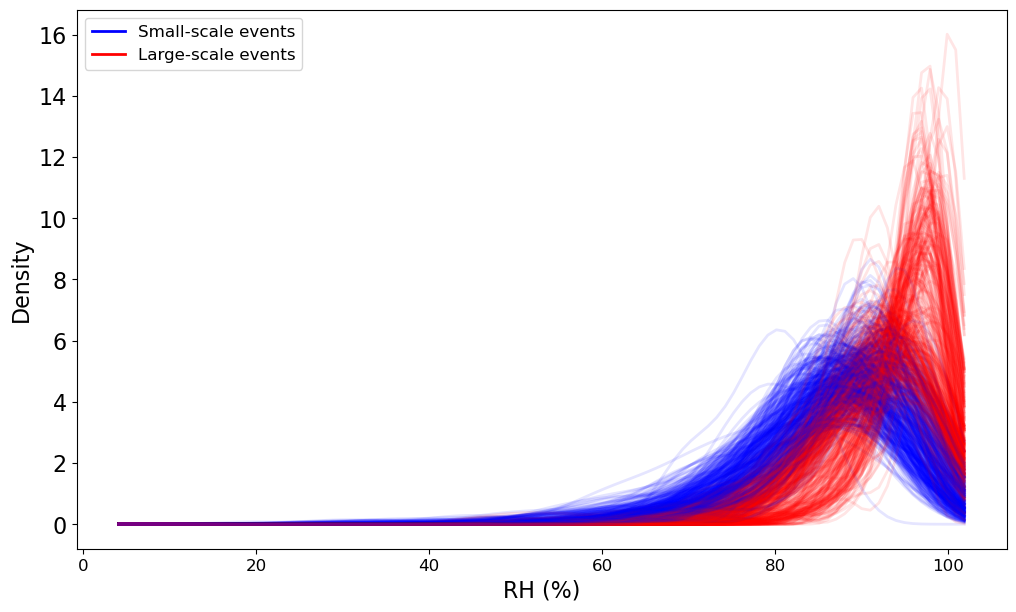

In [24]:
plt.figure()
for i in range(0, rh850_small_kde_group.shape[0]):
    plt.plot(rh850_all_x, rh850_large_kde_group[i,:], color="red", alpha=0.1)


    plt.plot(rh850_all_x, rh850_small_kde_group[i,:], color="blue", alpha=0.1)

# Add one representative line for each group with a label
plt.plot([], [], color="blue", label="Small-scale events")
plt.plot([], [], color="red", label="Large-scale events")

# Add legend
plt.legend()

plt.xlabel("RH (%)")
plt.ylabel("Density")


#### plotting

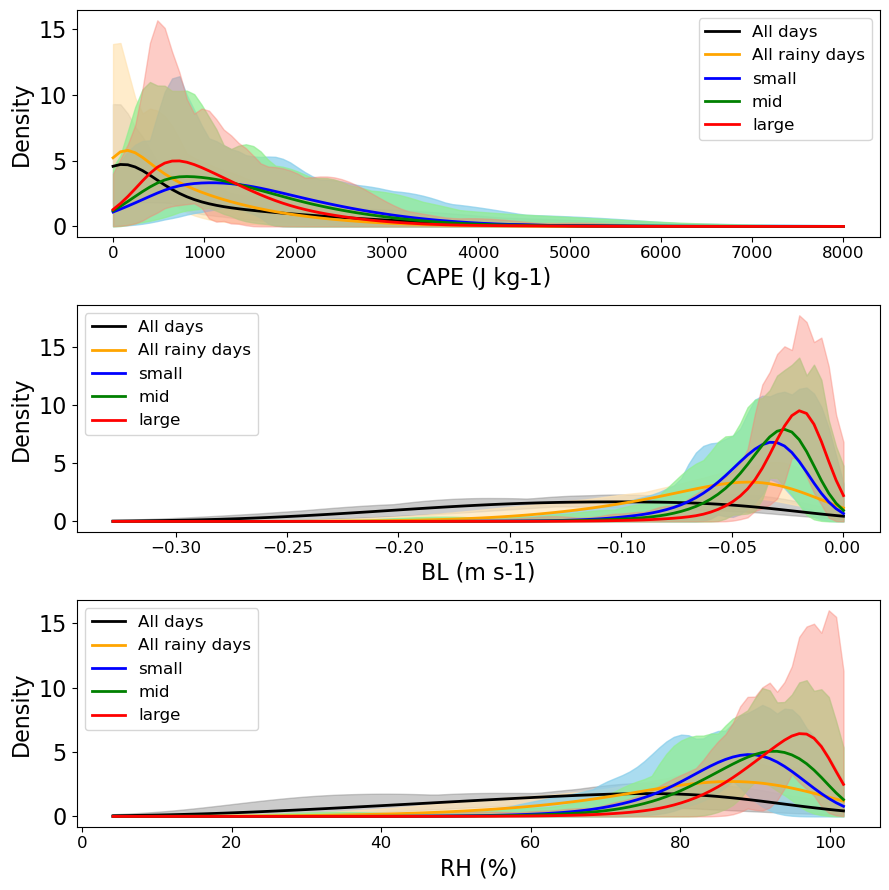

In [20]:
plt.figure(figsize=(9,9))
plt.subplot(311)
plt.fill_between(cape_all_x, np.min(cape_all_kde_group,axis=0), np.max(cape_all_kde_group,axis=0), color="gray", alpha=0.4)
plt.plot(cape_all_x, np.mean(cape_all_kde_group,axis=0), color="k", label="All days")

plt.fill_between(cape_all_x, np.min(cape_rainy_kde_group,axis=0), np.max(cape_rainy_kde_group,axis=0), color="moccasin", alpha=0.7)
plt.plot(cape_rainy_x, np.mean(cape_rainy_kde_group,axis=0), color="orange", label="All rainy days")

plt.fill_between(cape_all_x, np.min(cape_small_kde_group,axis=0), np.max(cape_small_kde_group,axis=0), color="skyblue", alpha=0.7)
plt.plot(cape_all_x, np.mean(cape_small_kde_group,axis=0), color="blue", label="small")

plt.fill_between(cape_all_x, np.min(cape_mid_kde_group,axis=0), np.max(cape_mid_kde_group,axis=0), color="lightgreen", alpha=0.7)
plt.plot(cape_all_x, np.mean(cape_mid_kde_group,axis=0), color="green", label="mid")


plt.fill_between(cape_all_x, np.min(cape_large_kde_group,axis=0), np.max(cape_large_kde_group,axis=0), color="salmon", alpha=0.4)
plt.plot(cape_all_x, np.mean(cape_large_kde_group,axis=0), color="red", label="large")


plt.xlabel("CAPE (J kg-1)")
plt.ylabel("Density")

plt.legend()

plt.subplot(312)

plt.fill_between(bl_all_x, np.min(bl_all_kde_group,axis=0), np.max(bl_all_kde_group,axis=0), color="gray", alpha=0.4)
plt.plot(bl_all_x, np.mean(bl_all_kde_group,axis=0), color="k", label="All days")

plt.fill_between(bl_all_x, np.min(bl_rainy_kde_group,axis=0), np.max(bl_rainy_kde_group,axis=0), color="moccasin", alpha=0.7)
plt.plot(bl_all_x, np.mean(bl_rainy_kde_group,axis=0), color="orange", label="All rainy days")

plt.fill_between(bl_all_x, np.min(bl_small_kde_group,axis=0), np.max(bl_small_kde_group,axis=0), color="skyblue", alpha=0.7)
plt.plot(bl_all_x, np.mean(bl_small_kde_group,axis=0), color="blue", label="small")

plt.fill_between(bl_all_x, np.min(bl_mid_kde_group,axis=0), np.max(bl_mid_kde_group,axis=0), color="lightgreen", alpha=0.7)
plt.plot(bl_all_x, np.mean(bl_mid_kde_group,axis=0), color="green", label="mid")

plt.fill_between(bl_all_x, np.min(bl_large_kde_group,axis=0), np.max(bl_large_kde_group,axis=0), color="salmon", alpha=0.4)
plt.plot(bl_all_x, np.mean(bl_large_kde_group,axis=0), color="red", label="large")



plt.legend(loc="upper left")
plt.xlabel("BL (m s-1)")
plt.ylabel("Density")

plt.subplot(313)
plt.fill_between(rh850_all_x, np.min(rh850_all_kde_group,axis=0), np.max(rh850_all_kde_group,axis=0), color="gray", alpha=0.4)
plt.plot(rh850_all_x, np.mean(rh850_all_kde_group,axis=0), color="k", label="All days")

plt.fill_between(rh850_all_x, np.min(rh850_rainy_kde_group,axis=0), np.max(rh850_rainy_kde_group,axis=0), color="moccasin", alpha=0.7)
plt.plot(rh850_all_x, np.mean(rh850_rainy_kde_group,axis=0), color="orange", label="All rainy days")

plt.fill_between(rh850_all_x, np.min(rh850_small_kde_group,axis=0), np.max(rh850_small_kde_group,axis=0), color="skyblue", alpha=0.7)
plt.plot(rh850_all_x, np.mean(rh850_small_kde_group,axis=0), color="blue", label="small")

plt.fill_between(rh850_all_x, np.min(rh850_mid_kde_group,axis=0), np.max(rh850_mid_kde_group,axis=0), color="lightgreen", alpha=0.7)
plt.plot(rh850_all_x, np.mean(rh850_mid_kde_group,axis=0), color="green", label="mid")

plt.fill_between(rh850_all_x, np.min(rh850_large_kde_group,axis=0), np.max(rh850_large_kde_group,axis=0), color="salmon", alpha=0.4)
plt.plot(rh850_all_x, np.mean(rh850_large_kde_group,axis=0), color="red", label="large")

plt.legend(loc="upper left")
plt.xlabel("RH (%)")
plt.ylabel("Density")
plt.tight_layout()

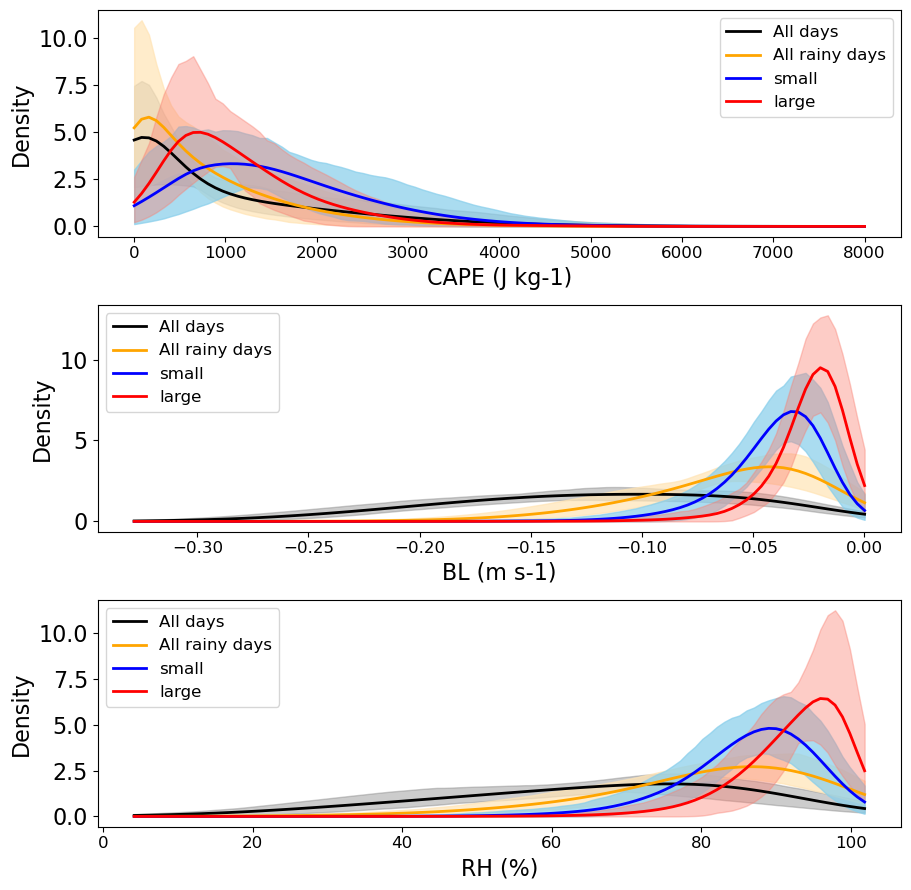

In [23]:
plt.figure(figsize=(9,9))
plt.subplot(311)
plt.fill_between(cape_all_x, np.percentile(cape_all_kde_group,5,axis=0), np.percentile(cape_all_kde_group,95,axis=0), color="gray", alpha=0.4)
plt.plot(cape_all_x, np.mean(cape_all_kde_group,axis=0), color="k", label="All days")

plt.fill_between(cape_all_x, np.percentile(cape_rainy_kde_group,5,axis=0), np.percentile(cape_rainy_kde_group,95,axis=0), color="moccasin", alpha=0.7)
plt.plot(cape_rainy_x, np.mean(cape_rainy_kde_group,axis=0), color="orange", label="All rainy days")

plt.fill_between(cape_all_x, np.percentile(cape_small_kde_group,5,axis=0), np.percentile(cape_small_kde_group,95,axis=0), color="skyblue", alpha=0.7)
plt.plot(cape_all_x, np.mean(cape_small_kde_group,axis=0), color="blue", label="small")

# plt.fill_between(cape_all_x, np.percentile(cape_mid_kde_group,5,axis=0), np.percentile(cape_mid_kde_group,95,axis=0), color="lightgreen", alpha=0.7)
# plt.plot(cape_all_x, np.mean(cape_mid_kde_group,axis=0), color="green", label="mid")

plt.fill_between(cape_all_x, np.percentile(cape_large_kde_group,5,axis=0), np.percentile(cape_large_kde_group,95,axis=0), color="salmon", alpha=0.4)
plt.plot(cape_all_x, np.mean(cape_large_kde_group,axis=0), color="red", label="large")


plt.xlabel("CAPE (J kg-1)")
plt.ylabel("Density")

plt.legend()

plt.subplot(312)

plt.fill_between(bl_all_x, np.percentile(bl_all_kde_group,5,axis=0), np.percentile(bl_all_kde_group,95,axis=0), color="gray", alpha=0.4)
plt.plot(bl_all_x, np.mean(bl_all_kde_group,axis=0), color="k", label="All days")

plt.fill_between(bl_all_x, np.percentile(bl_rainy_kde_group,5,axis=0), np.percentile(bl_rainy_kde_group,95,axis=0), color="moccasin", alpha=0.7)
plt.plot(bl_all_x, np.mean(bl_rainy_kde_group,axis=0), color="orange", label="All rainy days")

plt.fill_between(bl_all_x, np.percentile(bl_small_kde_group,5,axis=0), np.percentile(bl_small_kde_group,95,axis=0), color="skyblue", alpha=0.7)
plt.plot(bl_all_x, np.mean(bl_small_kde_group,axis=0), color="blue", label="small")

# plt.fill_between(bl_all_x, np.percentile(bl_mid_kde_group,5,axis=0), np.percentile(bl_mid_kde_group,95,axis=0), color="lightgreen", alpha=0.7)
# plt.plot(bl_all_x, np.mean(bl_mid_kde_group,axis=0), color="green", label="mid")

plt.fill_between(bl_all_x, np.percentile(bl_large_kde_group,5,axis=0), np.percentile(bl_large_kde_group,95,axis=0), color="salmon", alpha=0.4)
plt.plot(bl_all_x, np.mean(bl_large_kde_group,axis=0), color="red", label="large")



plt.legend(loc="upper left")
plt.xlabel("BL (m s-1)")
plt.ylabel("Density")

plt.subplot(313)
plt.fill_between(rh850_all_x, np.percentile(rh850_all_kde_group,5,axis=0), np.percentile(rh850_all_kde_group,95,axis=0), color="gray", alpha=0.4)
plt.plot(rh850_all_x, np.mean(rh850_all_kde_group,axis=0), color="k", label="All days")

plt.fill_between(rh850_all_x, np.percentile(rh850_rainy_kde_group,5,axis=0), np.percentile(rh850_rainy_kde_group,95,axis=0), color="moccasin", alpha=0.7)
plt.plot(rh850_all_x, np.mean(rh850_rainy_kde_group,axis=0), color="orange", label="All rainy days")

plt.fill_between(rh850_all_x, np.percentile(rh850_small_kde_group,5,axis=0), np.percentile(rh850_small_kde_group,95,axis=0), color="skyblue", alpha=0.7)
plt.plot(rh850_all_x, np.mean(rh850_small_kde_group,axis=0), color="blue", label="small")

# plt.fill_between(rh850_all_x, np.percentile(rh850_mid_kde_group,5,axis=0), np.percentile(rh850_mid_kde_group,95,axis=0), color="lightgreen", alpha=0.7)
# plt.plot(rh850_all_x, np.mean(rh850_mid_kde_group,axis=0), color="green", label="mid")

plt.fill_between(rh850_all_x, np.percentile(rh850_large_kde_group,5,axis=0), np.percentile(rh850_large_kde_group,95,axis=0), color="salmon", alpha=0.4)
plt.plot(rh850_all_x, np.mean(rh850_large_kde_group,axis=0), color="red", label="large")

plt.legend(loc="upper left")
plt.xlabel("RH (%)")
plt.ylabel("Density")
plt.tight_layout()

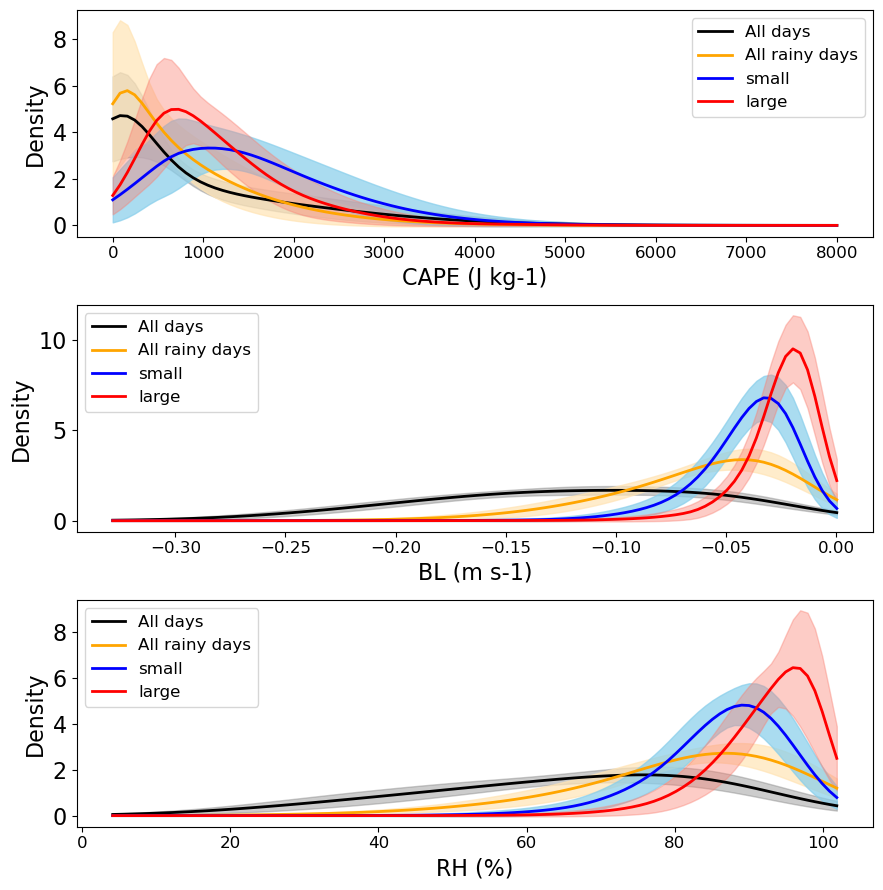

In [22]:
plt.figure(figsize=(9,9))
plt.subplot(311)
plt.fill_between(cape_all_x, np.mean(cape_all_kde_group,axis=0)-np.std(cape_all_kde_group,axis=0),
                 np.mean(cape_all_kde_group,axis=0)+np.std(cape_all_kde_group,axis=0), color="gray", alpha=0.4)
plt.plot(cape_all_x, np.mean(cape_all_kde_group,axis=0), color="k", label="All days")

plt.fill_between(cape_all_x, np.mean(cape_rainy_kde_group,axis=0)-np.std(cape_rainy_kde_group,axis=0),
                 np.mean(cape_rainy_kde_group,axis=0)+np.std(cape_rainy_kde_group,axis=0), color="moccasin", alpha=0.7)
plt.plot(cape_rainy_x, np.mean(cape_rainy_kde_group,axis=0), color="orange", label="All rainy days")

plt.fill_between(cape_all_x, np.mean(cape_small_kde_group,axis=0)-np.std(cape_small_kde_group,axis=0),
                 np.mean(cape_small_kde_group,axis=0)+np.std(cape_small_kde_group,axis=0), color="skyblue", alpha=0.7)
plt.plot(cape_all_x, np.mean(cape_small_kde_group,axis=0), color="blue", label="small")

plt.fill_between(cape_all_x, np.mean(cape_large_kde_group,axis=0)-np.std(cape_large_kde_group,axis=0),
                 np.mean(cape_large_kde_group,axis=0)+np.std(cape_large_kde_group,axis=0), color="salmon", alpha=0.4)
plt.plot(cape_all_x, np.mean(cape_large_kde_group,axis=0), color="red", label="large")


plt.xlabel("CAPE (J kg-1)")
plt.ylabel("Density")

plt.legend()

plt.subplot(312)

plt.fill_between(bl_all_x, np.mean(bl_all_kde_group,axis=0)-np.std(bl_all_kde_group,axis=0),
                 np.mean(bl_all_kde_group,axis=0)+np.std(bl_all_kde_group,axis=0), color="gray", alpha=0.4)
plt.plot(bl_all_x, np.mean(bl_all_kde_group,axis=0), color="k", label="All days")

plt.fill_between(bl_all_x, np.mean(bl_rainy_kde_group,axis=0)-np.std(bl_rainy_kde_group,axis=0),
                 np.mean(bl_rainy_kde_group,axis=0)+np.std(bl_rainy_kde_group,axis=0), color="moccasin", alpha=0.7)
plt.plot(bl_all_x, np.mean(bl_rainy_kde_group,axis=0), color="orange", label="All rainy days")

plt.fill_between(bl_all_x, np.mean(bl_small_kde_group,axis=0)-np.std(bl_small_kde_group,axis=0),
                 np.mean(bl_small_kde_group,axis=0)+np.std(bl_small_kde_group,axis=0), color="skyblue", alpha=0.7)
plt.plot(bl_all_x, np.mean(bl_small_kde_group,axis=0), color="blue", label="small")

plt.fill_between(bl_all_x, np.mean(bl_large_kde_group,axis=0)-np.std(bl_large_kde_group,axis=0),
                 np.mean(bl_large_kde_group,axis=0)+np.std(bl_large_kde_group,axis=0), color="salmon", alpha=0.4)
plt.plot(bl_all_x, np.mean(bl_large_kde_group,axis=0), color="red", label="large")



plt.legend(loc="upper left")
plt.xlabel("BL (m s-1)")
plt.ylabel("Density")

plt.subplot(313)
plt.fill_between(rh850_all_x, np.mean(rh850_all_kde_group,axis=0)-np.std(rh850_all_kde_group,axis=0),
                 np.mean(rh850_all_kde_group,axis=0)+np.std(rh850_all_kde_group,axis=0), color="gray", alpha=0.4)
plt.plot(rh850_all_x, np.mean(rh850_all_kde_group,axis=0), color="k", label="All days")

plt.fill_between(rh850_all_x, np.mean(rh850_rainy_kde_group,axis=0)-np.std(rh850_rainy_kde_group,axis=0),
                 np.mean(rh850_rainy_kde_group,axis=0)+np.std(rh850_rainy_kde_group,axis=0), color="moccasin", alpha=0.7)
plt.plot(rh850_all_x, np.mean(rh850_rainy_kde_group,axis=0), color="orange", label="All rainy days")

plt.fill_between(rh850_all_x, np.mean(rh850_small_kde_group,axis=0)-np.std(rh850_small_kde_group,axis=0),
                 np.mean(rh850_small_kde_group,axis=0)+np.std(rh850_small_kde_group,axis=0), color="skyblue", alpha=0.7)
plt.plot(rh850_all_x, np.mean(rh850_small_kde_group,axis=0), color="blue", label="small")

plt.fill_between(rh850_all_x, np.mean(rh850_large_kde_group,axis=0)-np.std(rh850_large_kde_group,axis=0),
                 np.mean(rh850_large_kde_group,axis=0)+np.std(rh850_large_kde_group,axis=0),color="salmon", alpha=0.4)
plt.plot(rh850_all_x, np.mean(rh850_large_kde_group,axis=0), color="red", label="large")

plt.legend(loc="upper left")
plt.xlabel("RH (%)")
plt.ylabel("Density")
plt.tight_layout()

### all stations -10$\degree$ to -23.5$\degree$

In [12]:
files = glob("/g/data/k10/dl6968/Semi-variogram_AU/data/tropical_stn_env/*_all_days.csv")
cape_kde_dict = {}
bl_kde_dict = {}
rh850_kde_dict = {}

for file in tqdm(files,position=0,leave=True, total=len(files)):
    spec_id = file.replace("/g/data/k10/dl6968/Semi-variogram_AU/data/tropical_stn_env/","").replace("_all_days.csv","") 
    df_allD = pd.read_csv(file)
    df_rainy = pd.read_csv(file.replace("all_days","rainy"))
    df_small = pd.read_csv(file.replace("all_days","extreme_small"))
    df_large = pd.read_csv(file.replace("all_days","extreme_large"))
    if len(df_small)>=20 and len(df_large)>=20:
        cape_all_x, cape_all_kde = get_kde1(df_allD["CAPE"].values,df_allD["CAPE"].min(),df_allD["CAPE"].max())
        cape_rainy_x, cape_rainy_kde = get_kde1(df_rainy["CAPE"].values,cape_all_x.min(),cape_all_x.max()) 
        cape_small_x, cape_small_kde = get_kde1(df_small["CAPE"].values,cape_all_x.min(),cape_all_x.max()) 
        cape_large_x, cape_large_kde = get_kde1(df_large["CAPE"].values,cape_all_x.min(),cape_all_x.max()) 
    
        
        bl_all_x, bl_all_kde = get_kde1(df_allD["BL"].values,df_allD["BL"].min(),df_allD["BL"].max())
        bl_rainy_x, bl_rainy_kde = get_kde1(df_rainy["BL"].values,bl_all_x.min(),bl_all_x.max()) 
        bl_small_x, bl_small_kde = get_kde1(df_small["BL"].values,bl_all_x.min(),bl_all_x.max()) 
        bl_large_x, bl_large_kde = get_kde1(df_large["BL"].values,bl_all_x.min(),bl_all_x.max()) 
        
        rh850_all_x, rh850_all_kde = get_kde1(df_allD["RH"].values,df_allD["RH"].min(),df_allD["RH"].max())
        rh850_rainy_x, rh850_rainy_kde = get_kde1(df_rainy["RH"].values,rh850_all_x.min(),rh850_all_x.max()) 
        rh850_small_x, rh850_small_kde = get_kde1(df_small["RH"].values,rh850_all_x.min(),rh850_all_x.max()) 
        rh850_large_x, rh850_large_kde = get_kde1(df_large["RH"].values,rh850_all_x.min(),rh850_all_x.max()) 
    
        cape_kde_dict[spec_id] = [cape_all_x, cape_all_kde,  cape_rainy_kde,  cape_small_kde, cape_large_kde]
        bl_kde_dict[spec_id] = [bl_all_x, bl_all_kde,  bl_rainy_kde,  bl_small_kde, bl_large_kde]
        rh850_kde_dict[spec_id] = [rh850_all_x, rh850_all_kde,  rh850_rainy_kde,  rh850_small_kde, rh850_large_kde]

100%|██████████| 1484/1484 [09:20<00:00,  2.65it/s]


In [13]:
len(cape_kde_dict)

1089

In [14]:
def group_kdes_tp(kde_dict):
    spec_id = list(kde_dict.keys())[0]
    all_kde_group = np.zeros((len(kde_dict), kde_dict[spec_id][1].shape[0]))
    rainy_kde_group = np.zeros((len(kde_dict), kde_dict[spec_id][2].shape[0]))
    p20_kde_group = np.zeros((len(kde_dict), kde_dict[spec_id][3].shape[0]))
    p80_kde_group = np.zeros((len(kde_dict), kde_dict[spec_id][4].shape[0]))
    for i, spec_id in enumerate(kde_dict.keys()):
        all_kde_group[i,:] = kde_dict[spec_id][1]
        rainy_kde_group[i,:] = kde_dict[spec_id][2]
        p20_kde_group[i,:] = kde_dict[spec_id][3]
        p80_kde_group[i,:] = kde_dict[spec_id][4]
    return all_kde_group, rainy_kde_group, p20_kde_group, p80_kde_group

In [15]:
cape_all_kde_group, cape_rainy_kde_group, cape_small_kde_group, cape_large_kde_group = group_kdes_tp(cape_kde_dict)
bl_all_kde_group, bl_rainy_kde_group, bl_small_kde_group, bl_large_kde_group = group_kdes_tp(bl_kde_dict)
rh850_all_kde_group, rh850_rainy_kde_group, rh850_small_kde_group, rh850_large_kde_group = group_kdes_tp(rh850_kde_dict)


In [ ]:
plt.figure()
for i in range(0, rh850_small_kde_group.shape[0]):
    plt.plot(rh850_all_x, rh850_small_kde_group[i,:], color="blue", alpha=0.1)
    plt.plot(rh850_all_x, rh850_large_kde_group[i,:], color="red", alpha=0.1)

# Add one representative line for each group with a label
plt.plot([], [], color="blue", label="Small-scale events")
plt.plot([], [], color="red", label="Large-scale events")

# Add legend
plt.legend()

plt.xlabel("RH (%)")
plt.ylabel("Density")


Text(0, 0.5, 'Density')

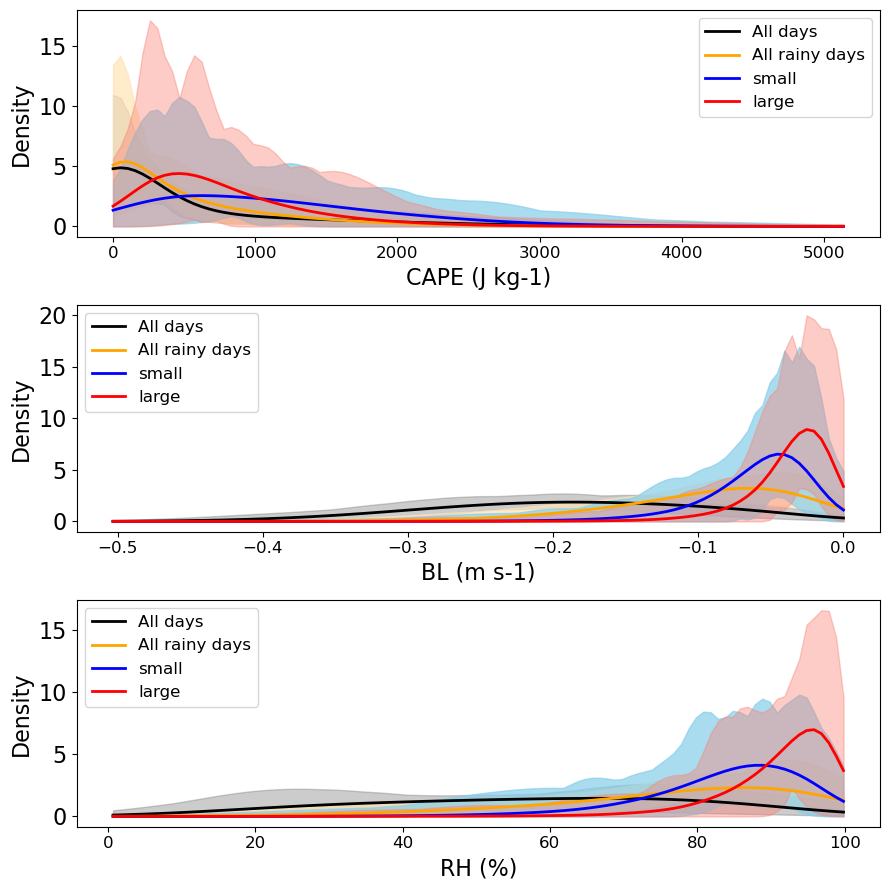

In [16]:
plt.figure(figsize=(9,9))
plt.subplot(311)
plt.fill_between(cape_all_x, np.min(cape_all_kde_group,axis=0), np.max(cape_all_kde_group,axis=0), color="gray", alpha=0.4)
plt.plot(cape_all_x, np.mean(cape_all_kde_group,axis=0), color="k", label="All days")

plt.fill_between(cape_all_x, np.min(cape_rainy_kde_group,axis=0), np.max(cape_rainy_kde_group,axis=0), color="moccasin", alpha=0.7)
plt.plot(cape_rainy_x, np.mean(cape_rainy_kde_group,axis=0), color="orange", label="All rainy days")

plt.fill_between(cape_all_x, np.min(cape_small_kde_group,axis=0), np.max(cape_small_kde_group,axis=0), color="skyblue", alpha=0.7)
plt.plot(cape_all_x, np.mean(cape_small_kde_group,axis=0), color="blue", label="small")

plt.fill_between(cape_all_x, np.min(cape_large_kde_group,axis=0), np.max(cape_large_kde_group,axis=0), color="salmon", alpha=0.4)
plt.plot(cape_all_x, np.mean(cape_large_kde_group,axis=0), color="red", label="large")


plt.xlabel("CAPE (J kg-1)")
plt.ylabel("Density")

plt.legend()

plt.subplot(312)

plt.fill_between(bl_all_x, np.min(bl_all_kde_group,axis=0), np.max(bl_all_kde_group,axis=0), color="gray", alpha=0.4)
plt.plot(bl_all_x, np.mean(bl_all_kde_group,axis=0), color="k", label="All days")

plt.fill_between(bl_all_x, np.min(bl_rainy_kde_group,axis=0), np.max(bl_rainy_kde_group,axis=0), color="moccasin", alpha=0.7)
plt.plot(bl_all_x, np.mean(bl_rainy_kde_group,axis=0), color="orange", label="All rainy days")

plt.fill_between(bl_all_x, np.min(bl_small_kde_group,axis=0), np.max(bl_small_kde_group,axis=0), color="skyblue", alpha=0.7)
plt.plot(bl_all_x, np.mean(bl_small_kde_group,axis=0), color="blue", label="small")

plt.fill_between(bl_all_x, np.min(bl_large_kde_group,axis=0), np.max(bl_large_kde_group,axis=0), color="salmon", alpha=0.4)
plt.plot(bl_all_x, np.mean(bl_large_kde_group,axis=0), color="red", label="large")



plt.legend(loc="upper left")
plt.xlabel("BL (m s-1)")
plt.ylabel("Density")

plt.subplot(313)
plt.fill_between(rh850_all_x, np.min(rh850_all_kde_group,axis=0), np.max(rh850_all_kde_group,axis=0), color="gray", alpha=0.4)
plt.plot(rh850_all_x, np.mean(rh850_all_kde_group,axis=0), color="k", label="All days")

plt.fill_between(rh850_all_x, np.min(rh850_rainy_kde_group,axis=0), np.max(rh850_rainy_kde_group,axis=0), color="moccasin", alpha=0.7)
plt.plot(rh850_all_x, np.mean(rh850_rainy_kde_group,axis=0), color="orange", label="All rainy days")

plt.fill_between(rh850_all_x, np.min(rh850_small_kde_group,axis=0), np.max(rh850_small_kde_group,axis=0), color="skyblue", alpha=0.7)
plt.plot(rh850_all_x, np.mean(rh850_small_kde_group,axis=0), color="blue", label="small")

plt.fill_between(rh850_all_x, np.min(rh850_large_kde_group,axis=0), np.max(rh850_large_kde_group,axis=0), color="salmon", alpha=0.4)
plt.plot(rh850_all_x, np.mean(rh850_large_kde_group,axis=0), color="red", label="large")

plt.legend(loc="upper left")
plt.xlabel("RH (%)")
plt.ylabel("Density")
plt.tight_layout()

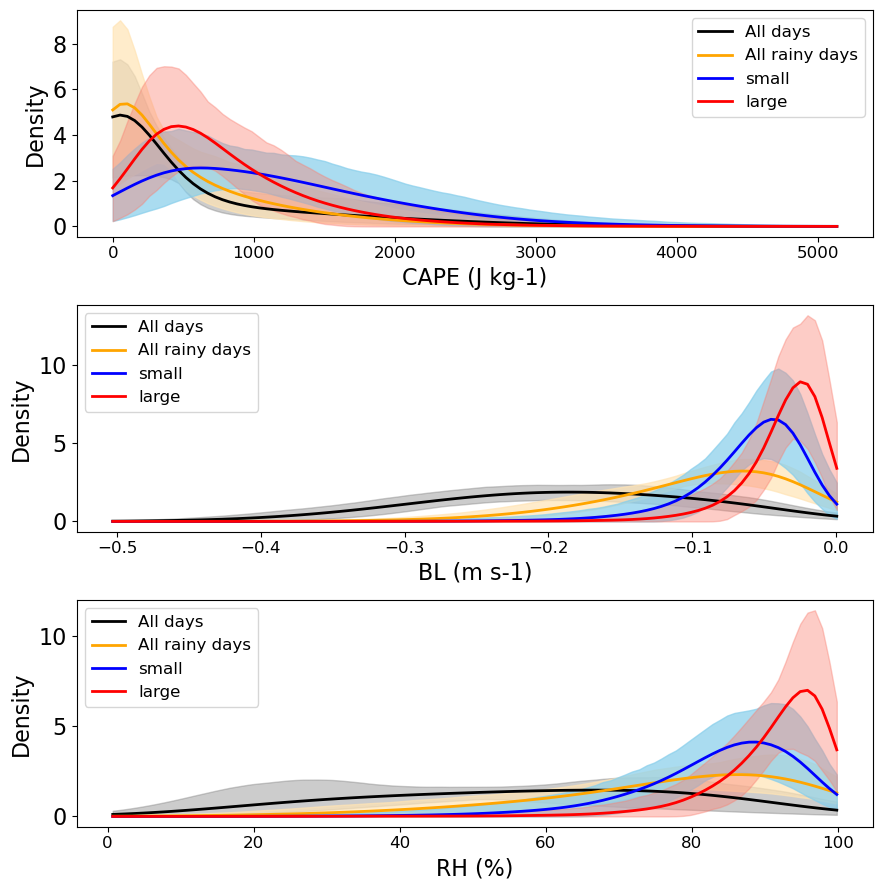

In [17]:
plt.figure(figsize=(9,9))
plt.subplot(311)
plt.fill_between(cape_all_x, np.percentile(cape_all_kde_group,5,axis=0), np.percentile(cape_all_kde_group,95,axis=0), color="gray", alpha=0.4)
plt.plot(cape_all_x, np.mean(cape_all_kde_group,axis=0), color="k", label="All days")

plt.fill_between(cape_all_x, np.percentile(cape_rainy_kde_group,5,axis=0), np.percentile(cape_rainy_kde_group,95,axis=0), color="moccasin", alpha=0.7)
plt.plot(cape_rainy_x, np.mean(cape_rainy_kde_group,axis=0), color="orange", label="All rainy days")

plt.fill_between(cape_all_x, np.percentile(cape_small_kde_group,5,axis=0), np.percentile(cape_small_kde_group,95,axis=0), color="skyblue", alpha=0.7)
plt.plot(cape_all_x, np.mean(cape_small_kde_group,axis=0), color="blue", label="small")

plt.fill_between(cape_all_x, np.percentile(cape_large_kde_group,5,axis=0), np.percentile(cape_large_kde_group,95,axis=0), color="salmon", alpha=0.4)
plt.plot(cape_all_x, np.mean(cape_large_kde_group,axis=0), color="red", label="large")


plt.xlabel("CAPE (J kg-1)")
plt.ylabel("Density")

plt.legend()

plt.subplot(312)

plt.fill_between(bl_all_x, np.percentile(bl_all_kde_group,5,axis=0), np.percentile(bl_all_kde_group,95,axis=0), color="gray", alpha=0.4)
plt.plot(bl_all_x, np.mean(bl_all_kde_group,axis=0), color="k", label="All days")

plt.fill_between(bl_all_x, np.percentile(bl_rainy_kde_group,5,axis=0), np.percentile(bl_rainy_kde_group,95,axis=0), color="moccasin", alpha=0.7)
plt.plot(bl_all_x, np.mean(bl_rainy_kde_group,axis=0), color="orange", label="All rainy days")

plt.fill_between(bl_all_x, np.percentile(bl_small_kde_group,5,axis=0), np.percentile(bl_small_kde_group,95,axis=0), color="skyblue", alpha=0.7)
plt.plot(bl_all_x, np.mean(bl_small_kde_group,axis=0), color="blue", label="small")

plt.fill_between(bl_all_x, np.percentile(bl_large_kde_group,5,axis=0), np.percentile(bl_large_kde_group,95,axis=0), color="salmon", alpha=0.4)
plt.plot(bl_all_x, np.mean(bl_large_kde_group,axis=0), color="red", label="large")



plt.legend(loc="upper left")
plt.xlabel("BL (m s-1)")
plt.ylabel("Density")

plt.subplot(313)
plt.fill_between(rh850_all_x, np.percentile(rh850_all_kde_group,5,axis=0), np.percentile(rh850_all_kde_group,95,axis=0), color="gray", alpha=0.4)
plt.plot(rh850_all_x, np.mean(rh850_all_kde_group,axis=0), color="k", label="All days")

plt.fill_between(rh850_all_x, np.percentile(rh850_rainy_kde_group,5,axis=0), np.percentile(rh850_rainy_kde_group,95,axis=0), color="moccasin", alpha=0.7)
plt.plot(rh850_all_x, np.mean(rh850_rainy_kde_group,axis=0), color="orange", label="All rainy days")

plt.fill_between(rh850_all_x, np.percentile(rh850_small_kde_group,5,axis=0), np.percentile(rh850_small_kde_group,95,axis=0), color="skyblue", alpha=0.7)
plt.plot(rh850_all_x, np.mean(rh850_small_kde_group,axis=0), color="blue", label="small")

plt.fill_between(rh850_all_x, np.percentile(rh850_large_kde_group,5,axis=0), np.percentile(rh850_large_kde_group,95,axis=0), color="salmon", alpha=0.4)
plt.plot(rh850_all_x, np.mean(rh850_large_kde_group,axis=0), color="red", label="large")

plt.legend(loc="upper left")
plt.xlabel("RH (%)")
plt.ylabel("Density")
plt.tight_layout()

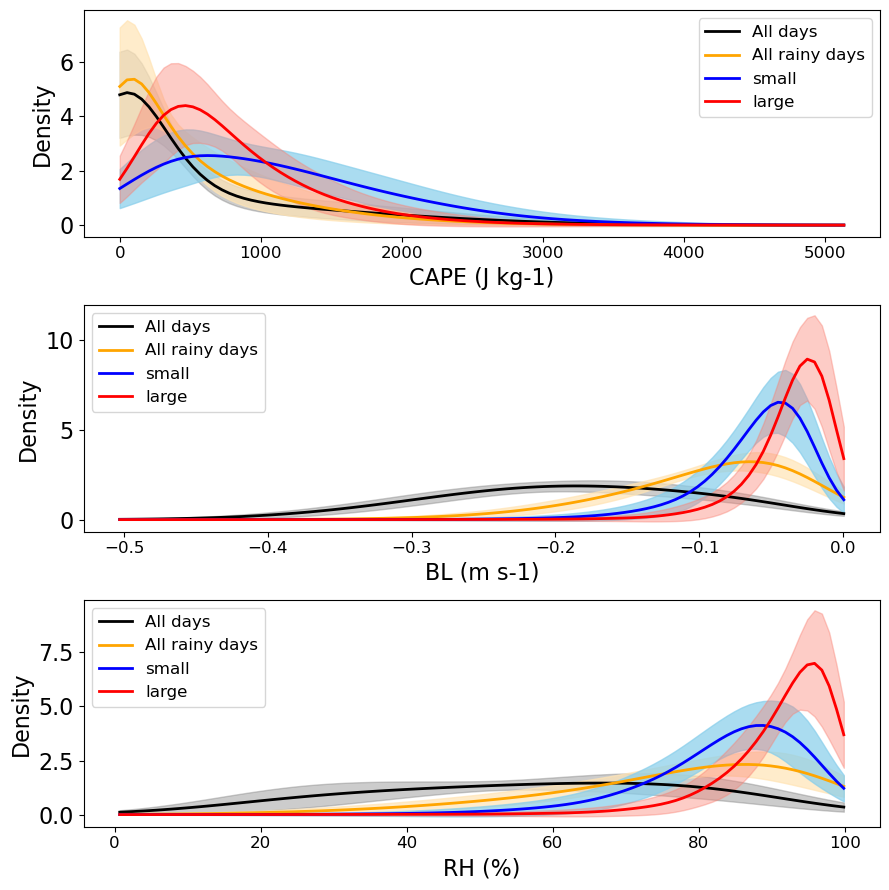

In [18]:
plt.figure(figsize=(9,9))
plt.subplot(311)
plt.fill_between(cape_all_x, np.mean(cape_all_kde_group,axis=0)-np.std(cape_all_kde_group,axis=0),
                 np.mean(cape_all_kde_group,axis=0)+np.std(cape_all_kde_group,axis=0), color="gray", alpha=0.4)
plt.plot(cape_all_x, np.mean(cape_all_kde_group,axis=0), color="k", label="All days")

plt.fill_between(cape_all_x, np.mean(cape_rainy_kde_group,axis=0)-np.std(cape_rainy_kde_group,axis=0),
                 np.mean(cape_rainy_kde_group,axis=0)+np.std(cape_rainy_kde_group,axis=0), color="moccasin", alpha=0.7)
plt.plot(cape_rainy_x, np.mean(cape_rainy_kde_group,axis=0), color="orange", label="All rainy days")

plt.fill_between(cape_all_x, np.mean(cape_small_kde_group,axis=0)-np.std(cape_small_kde_group,axis=0),
                 np.mean(cape_small_kde_group,axis=0)+np.std(cape_small_kde_group,axis=0), color="skyblue", alpha=0.7)
plt.plot(cape_all_x, np.mean(cape_small_kde_group,axis=0), color="blue", label="small")

plt.fill_between(cape_all_x, np.mean(cape_large_kde_group,axis=0)-np.std(cape_large_kde_group,axis=0),
                 np.mean(cape_large_kde_group,axis=0)+np.std(cape_large_kde_group,axis=0), color="salmon", alpha=0.4)
plt.plot(cape_all_x, np.mean(cape_large_kde_group,axis=0), color="red", label="large")


plt.xlabel("CAPE (J kg-1)")
plt.ylabel("Density")

plt.legend()

plt.subplot(312)

plt.fill_between(bl_all_x, np.mean(bl_all_kde_group,axis=0)-np.std(bl_all_kde_group,axis=0),
                 np.mean(bl_all_kde_group,axis=0)+np.std(bl_all_kde_group,axis=0), color="gray", alpha=0.4)
plt.plot(bl_all_x, np.mean(bl_all_kde_group,axis=0), color="k", label="All days")

plt.fill_between(bl_all_x, np.mean(bl_rainy_kde_group,axis=0)-np.std(bl_rainy_kde_group,axis=0),
                 np.mean(bl_rainy_kde_group,axis=0)+np.std(bl_rainy_kde_group,axis=0), color="moccasin", alpha=0.7)
plt.plot(bl_all_x, np.mean(bl_rainy_kde_group,axis=0), color="orange", label="All rainy days")

plt.fill_between(bl_all_x, np.mean(bl_small_kde_group,axis=0)-np.std(bl_small_kde_group,axis=0),
                 np.mean(bl_small_kde_group,axis=0)+np.std(bl_small_kde_group,axis=0), color="skyblue", alpha=0.7)
plt.plot(bl_all_x, np.mean(bl_small_kde_group,axis=0), color="blue", label="small")

plt.fill_between(bl_all_x, np.mean(bl_large_kde_group,axis=0)-np.std(bl_large_kde_group,axis=0),
                 np.mean(bl_large_kde_group,axis=0)+np.std(bl_large_kde_group,axis=0), color="salmon", alpha=0.4)
plt.plot(bl_all_x, np.mean(bl_large_kde_group,axis=0), color="red", label="large")



plt.legend(loc="upper left")
plt.xlabel("BL (m s-1)")
plt.ylabel("Density")

plt.subplot(313)
plt.fill_between(rh850_all_x, np.mean(rh850_all_kde_group,axis=0)-np.std(rh850_all_kde_group,axis=0),
                 np.mean(rh850_all_kde_group,axis=0)+np.std(rh850_all_kde_group,axis=0), color="gray", alpha=0.4)
plt.plot(rh850_all_x, np.mean(rh850_all_kde_group,axis=0), color="k", label="All days")

plt.fill_between(rh850_all_x, np.mean(rh850_rainy_kde_group,axis=0)-np.std(rh850_rainy_kde_group,axis=0),
                 np.mean(rh850_rainy_kde_group,axis=0)+np.std(rh850_rainy_kde_group,axis=0), color="moccasin", alpha=0.7)
plt.plot(rh850_all_x, np.mean(rh850_rainy_kde_group,axis=0), color="orange", label="All rainy days")

plt.fill_between(rh850_all_x, np.mean(rh850_small_kde_group,axis=0)-np.std(rh850_small_kde_group,axis=0),
                 np.mean(rh850_small_kde_group,axis=0)+np.std(rh850_small_kde_group,axis=0), color="skyblue", alpha=0.7)
plt.plot(rh850_all_x, np.mean(rh850_small_kde_group,axis=0), color="blue", label="small")

plt.fill_between(rh850_all_x, np.mean(rh850_large_kde_group,axis=0)-np.std(rh850_large_kde_group,axis=0),
                 np.mean(rh850_large_kde_group,axis=0)+np.std(rh850_large_kde_group,axis=0),color="salmon", alpha=0.4)
plt.plot(rh850_all_x, np.mean(rh850_large_kde_group,axis=0), color="red", label="large")

plt.legend(loc="upper left")
plt.xlabel("RH (%)")
plt.ylabel("Density")
plt.tight_layout()

## one station

In [28]:
(scale_p90, scale_p50, stn_count, rr_max_arr, rr_mean_arr, max_cape_arr, max_bl_arr, mean_subsatl_arr, mean_capel_arr, 
             mean_rh850_arr, mean_rh500_arr,bl_max_all,  cape_max_all,subast_all,  capel_all,rh850_all,rh500_all, bl_rainy_all,
           cape_rainy_all, subsat_rainy_all,capel_rainy_all,rh850_rainy_all,rh500_rainy_all) = get_bl_cape(14092)

In [29]:
p20 = np.percentile(scale_p90,20)
p80 = np.percentile(scale_p90,80)


In [30]:
cape_all_x, cape_all_kde = get_kde1(cape_max_all.values)
cape_rainy_x, cape_rainy_kde = get_kde1(cape_rainy_all.values,cape_all_x.min(),cape_all_x.max()) 
cape_x, cape_p20, cape_p80 = get_kde2(max_cape_arr[scale_p90<p20],max_cape_arr[scale_p90>=p80],cape_all_x.min(),cape_all_x.max())

bl_all_x, bl_all_kde = get_kde1(bl_max_all.values)
bl_rainy_x, bl_rainy_kde = get_kde1(bl_rainy_all.values,bl_all_x.min(),bl_all_x.max()) 
bl_x, bl_p20, bl_p80 = get_kde2(max_bl_arr[scale_p90<p20],max_bl_arr[scale_p90>=p80],bl_all_x.min(),bl_all_x.max())

rh850_all_x, rh850_all_kde = get_kde1(rh850_all.values)
rh850_rainy_x, rh850_rainy_kde = get_kde1(rh850_rainy_all.values,rh850_all_x.min(),rh850_all_x.max()) 

rh850_x, rh850_p20, rh850_p80 = get_kde2(mean_rh850_arr[scale_p90<p20],mean_rh850_arr[scale_p90>=p80],rh850_all_x.min(),rh850_all_x.max())

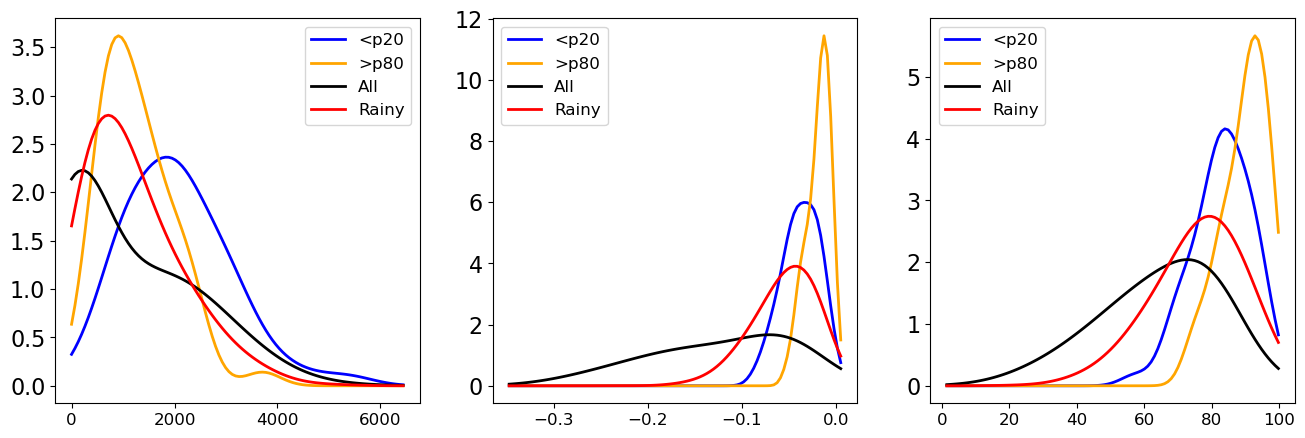

In [31]:
plt.figure(figsize=(16,5))
plt.subplot(131)
plt.plot(cape_x, cape_p20,color="b",label="<p20")
plt.plot(cape_x, cape_p80,color="orange",label=">p80")
plt.plot(cape_all_x, cape_all_kde,color="k",label="All")
plt.plot(cape_rainy_x, cape_rainy_kde,color="r",label="Rainy")

plt.legend()

plt.subplot(132)
plt.plot(bl_x, bl_p20,color="b",label="<p20")
plt.plot(bl_x, bl_p80,color="orange",label=">p80")
plt.plot(bl_all_x, bl_all_kde,color="k",label="All")
plt.plot(bl_rainy_x, bl_rainy_kde,color="r",label="Rainy")
plt.legend()
plt.subplot(133)
plt.plot(rh850_x, rh850_p20,color="b",label="<p20")
plt.plot(rh850_x, rh850_p80,color="orange",label=">p80")
plt.plot(rh850_all_x, rh850_all_kde,color="k",label="All")
plt.plot(rh850_rainy_x, rh850_rainy_kde,color="r",label="Rainy")
plt.legend()

## extract ERA5 for tropical AU

In [2]:
from dask.distributed import Client
client = Client(n_workers=28, threads_per_worker=1)  # set up local cluster on your laptop
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41947,Workers: 28
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 125.19 GiB
Comm: tcp://127.0.0.1:33767,Total threads: 1
Dashboard: /proxy/41297/status,Memory: 4.47 GiB
Nanny: tcp://127.0.0.1:40423,


In [3]:
ds_BL = xr.open_mfdataset("/scratch/k10/dl6968/ERA5_AU/tropical_-10_-23.5/tropical_BL.nc",
                          chunks={"time":3600,"latitude":20, "longitude":20},parallel=True)

ds_CAPE = xr.open_mfdataset("/scratch/k10/dl6968/ERA5_AU/tropical_-10_-23.5/tropical_CAPE.nc",
                          chunks={"time":3600,"latitude":20, "longitude":20},parallel=True)
ds_rh850 = xr.open_mfdataset("/scratch/k10/dl6968/ERA5_AU/tropical_-10_-23.5/tropical_rh850.nc",
                          chunks={"time":3600,"latitude":20, "longitude":20},parallel=True)


In [9]:
grouped_lons = np.split(ds_BL.longitude.values, len(ds_BL.longitude.values) // 6)

In [12]:
np.save( "/scratch/k10/dl6968/ERA5_AU/tropical_-10_-23.5/grouped_lones.npy",grouped_lons)

In [18]:
for i, lons in tqdm(enumerate(grouped_lons),total=len(grouped_lons), position=0, leave=True):
    ds_rh850_grouped = ds_rh850.sel(longitude=lons)
    ds_rh850_grouped = ds_rh850_grouped.load()
    ds_rh850_grouped.to_netcdf(f"/scratch/k10/dl6968/ERA5_AU/tropical_-10_-23.5/rh850_group{i:02d}.nc")
    ds_rh850_grouped.close()

100%|██████████| 31/31 [34:57<00:00, 67.67s/it]


In [29]:
client.close()